In [1]:
import pickle
import json
import os
import numpy as np
from bitsets import bitset
from matplotlib import pyplot as plt
import itertools

In [2]:
def calculate_SV(task, n_clients, experiment_type, round_choice):
    folder = '../fedtask/{}/record/'.format(task)
    if experiment_type == 'ideal':
        prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
    elif experiment_type == 'central':
        prefix = 'sv_central_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
    else:
        raise ValueError('param experiment_type must be in ["ideal", "central"]')
    if round_choice not in ['best', 'last']:
        raise ValueError('param experiment_type must be in ["best", "last"]')
    DICT = dict()
    files = os.listdir(folder)
    files.sort(reverse=True)
    for file in files:
        if file.startswith(prefix):
            with open(os.path.join(folder, file), 'r') as f:
                DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
    DICT['0' * n_clients] = np.zeros(101)
    CLIENTS_BITSET = bitset('clients_bitset', tuple(range(n_clients)))
    SV = list()
    for client in range(n_clients):
        result = 0.0
        rest_clients = [client_ for client_ in range(n_clients) if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                if round_choice == 'last':
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1] - \
                            DICT[CLIENTS_BITSET(subset).bits()][-1]
                        )
                elif round_choice == 'best':
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                            DICT[CLIENTS_BITSET(subset).bits()].max()
                        )
                count_i += 1
            a_i = a_i / count_i
            result += a_i
        result = result / len(range(n_clients))
        SV.append(result)
    SV = np.array(SV)
    filename = '{}_{}.npy'.format(experiment_type, round_choice)
    with open(os.path.join('../SV_result/', task, filename), 'wb') as f:
        pickle.dump(SV, f)
    print(task, experiment_type, round_choice)
    print(SV)
    return SV

In [3]:
# n_clients = 10
# for task in [
#     'synthetic_classification_cnum10_dist10_skew0.0_seed0',
#     'synthetic_classification_cnum10_dist10_skew0.5_seed0',
#     'synthetic_classification_cnum10_dist10_skew1.0_seed0',
#     'synthetic_classification_cnum10_dist11_skew1.0_seed0'
# ]:
#     for experiment_type in ['ideal', 'central']:
#         for round_choice in ['last', 'best']:
#             calculate_SV(task, n_clients, experiment_type, round_choice)

In [4]:
n_clients = 10
sv_dict = dict()
for task in [
    'synthetic_classification_cnum10_dist10_skew0.0_seed0',
    'synthetic_classification_cnum10_dist10_skew0.5_seed0',
    'synthetic_classification_cnum10_dist10_skew1.0_seed0',
    'synthetic_classification_cnum10_dist11_skew1.0_seed0'
]:
    if 'dist11' in task:
        key = 'IID'
    else:
        key = 'Non-IID ' + task.replace('_seed0', ''). \
            replace('synthetic_classification_cnum10_dist10_skew', '')
    with open('../SV_result/{}/ideal_best.npy'.format(task), 'rb') as f:
        ideal = pickle.load(f)
    with open('../SV_result/{}/central_best.npy'.format(task), 'rb') as f:
        central = pickle.load(f)
    exact = list()
    for round_ in range(1, 101):
        with open('../SV_result/{}/exact-10/Round{}.npy'.format(task, round_), 'rb') as f:
            exact.append(pickle.load(f).tolist())
    exact = np.array(exact)
    # alpha = np.power(0.5, np.arange(0, 100))
    # exact = np.dot(alpha, exact)
    exact = exact.sum(axis=0)
    sv_dict[key] = {
        'ideal': ideal,
        'central': central,
        'exact': exact
    }

In [5]:
exact = sv_dict['IID']['exact']
np.dot(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]))

array([22, 28])

In [6]:
def max_min(multiround_SV):
    result = np.dot(multiround_SV.max(axis=1) - multiround_SV.min(axis=1), multiround_SV)
    return result / result.sum()
def max_min_per_min(multiround_SV):
    result = np.dot((multiround_SV.max(axis=1) - multiround_SV.min(axis=1)) / multiround_SV.min(axis=1), multiround_SV)
    return result / result.sum()

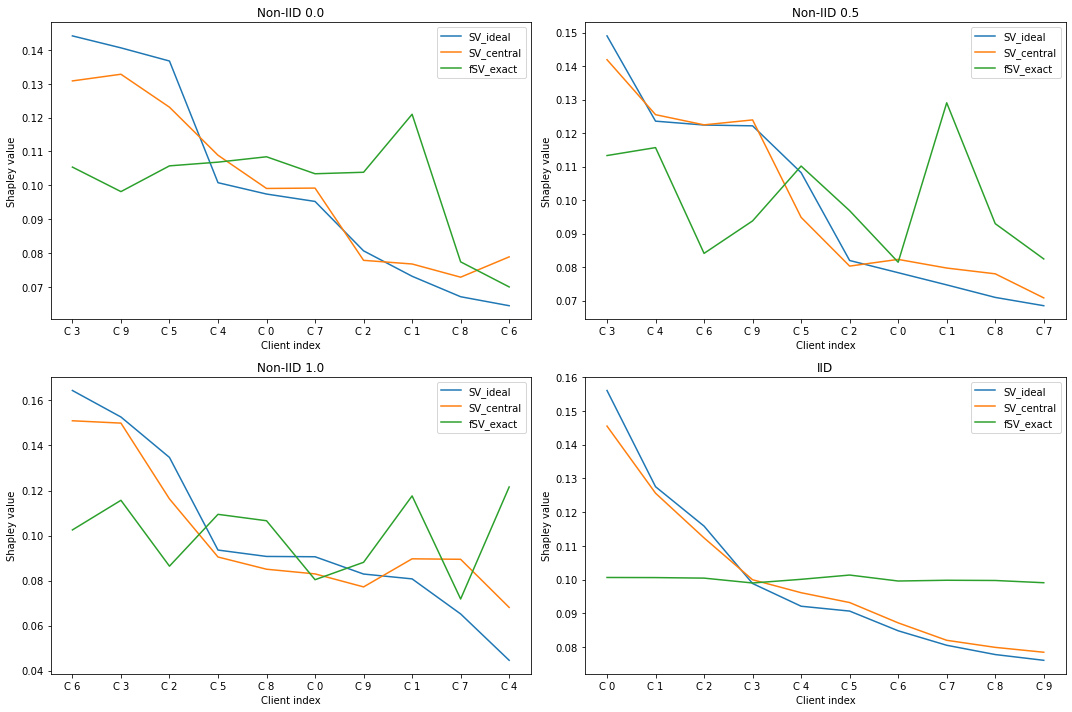

In [7]:
x = np.array(['C {}'.format(i) for i in range(n_clients)])
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
for index, (key, value) in enumerate(sv_dict.items()):
    sort_indices = np.argsort(value['ideal'])[::-1]
    ax[index // 2, index % 2].plot(x[sort_indices], (value['ideal'] / value['ideal'].sum())[sort_indices], label='SV_ideal')
    ax[index // 2, index % 2].plot(x[sort_indices], (value['central'] / value['central'].sum())[sort_indices], label='SV_central')
    ax[index // 2, index % 2].plot(x[sort_indices], (value['exact'] / value['exact'].sum())[sort_indices], label='fSV_exact')
    # ax[index // 2, index % 2].plot(x[sort_indices], max_min(value['exact'])[sort_indices], label='fSV_exact (max-min)')
    # ax[index // 2, index % 2].plot(x[sort_indices], max_min_per_min(value['exact'])[sort_indices], label='fSV_exact ((max-min)/min)')
    ax[index // 2, index % 2].legend()
    ax[index // 2, index % 2].set_title(key)
    ax[index // 2, index % 2].set_xlabel('Client index')
    ax[index // 2, index % 2].set_ylabel('Shapley value')
fig.tight_layout()
plt.savefig('../plots/Ideal and central.jpg')
plt.show()